In [2]:
%load_ext autoreload

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
# import AFAI_library as afai
import AFAI_library_torch as afai_cuda
import AFAI_parallelGPU as afai_parallel
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed

In [4]:
%autoreload 2

In [5]:
period = 2
hopping = - 3 * np.pi/(2 * period)
# model_test = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping, 2,2)
model = afai_cuda.tb_floquet_tbc_cuda(period, 1, hopping, 2)
np.set_printoptions(linewidth=300)

In [6]:
period = 2
hopping1 = - np.pi/(2)
hopping2 = - 3 * np.pi/(2)
hopping3 = - 5 * np.pi/(2)
np.set_printoptions(linewidth=300)

In [7]:
model_tbc1 = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping1, ny=2, nx=2, device='cuda:1')
model_tbc2 = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping2, ny=2, nx=2, device='cuda:1')
model_tbc3 = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping3, ny=2, nx=2, device='cuda:1')

In [11]:
model_pest1 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping1, num_y=2, device='cuda:1')
model_pest2 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping2, num_y=2, device='cuda:1')
model_pest3 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping3, num_y=2, device='cuda:1')

In [7]:
H1 = model.Hamiltonian_tbc1(2)
print(H1)

tensor([[ 0.0000+0.0000j,  0.0000+0.0000j,  2.3562-0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j, -0.9805-2.1425j],
        [ 2.3562+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j, -0.9805+2.1425j,  0.0000+0.0000j,  0.0000+0.0000j]],
       device='cuda:0', dtype=torch.complex128)


In [9]:
1j *np.log(np.exp(-1j * (np.pi)))

(3.141592653589793+7.498798913309288e-33j)

In [12]:
exp_value = np.exp(-1j * np.pi)
log_value = np.log(exp_value)
result = 1j * log_value

(exp_value, log_value, result)

((-1-1.2246467991473532e-16j),
 (7.498798913309288e-33-3.141592653589793j),
 (3.141592653589793+7.498798913309288e-33j))

In [24]:
exp_value = np.exp(1j * np.pi - 1.2246467991473532e-9j)
log_value = np.log(exp_value)
result = 1j * log_value

(exp_value, log_value, result)

((-1+1.2246467288105937e-09j),
 (7.498798051932439e-19+3.1415926523651465j),
 (-3.1415926523651465+7.498798051932439e-19j))

In [13]:
import torch

def log_with_branch_cut(z, branch_cut_angle=0):
    """
    Compute the complex logarithm with a custom branch cut.
    
    Parameters:
    z (torch.Tensor): Complex tensor
    branch_cut_angle (float): Angle (in radians) where the branch cut should be placed
    
    Returns:
    torch.Tensor: Complex logarithm with the specified branch cut
    """
    # Compute the standard complex logarithm
    log_z = torch.log(z)
    
    # Compute the argument (phase) of z
    arg_z = torch.angle(z)
    
    # Adjust the imaginary part based on the desired branch cut
    adjusted_arg = arg_z - branch_cut_angle
    adjusted_arg = (adjusted_arg + torch.pi) % (2 * torch.pi) - torch.pi
    
    # Construct the adjusted logarithm
    return torch.log(torch.abs(z)) + 1j * (adjusted_arg + branch_cut_angle)

In [14]:
# Standard logarithm (branch cut along negative real axis)
z = torch.tensor([-1 + 1j])
standard_log = torch.log(z)
print("Standard log:", standard_log)

# Logarithm with branch cut along positive imaginary axis
custom_log = log_with_branch_cut(z, branch_cut_angle=torch.pi/2)
print("Custom log:", custom_log)

Standard log: tensor([0.3466+2.3562j])
Custom log: tensor([0.3466+2.3562j])


In [2]:
def log_with_branch_cut(z, branch_cut_angle=0):
    # Step 1: Compute the magnitude of z
    magnitude = torch.abs(z)
    # Step 2: Compute the initial phase
    initial_phase = torch.angle(z)
    
    # Normalize the branch_cut_angle to be within [-pi, pi)
    branch_cut_angle = (branch_cut_angle + torch.pi) % (2 * torch.pi) - torch.pi

    # Step 3: Adjust phase to be within [branch_cut_angle, branch_cut_angle + 2*pi)
    adjusted_phase = initial_phase - branch_cut_angle
    adjusted_phase = (adjusted_phase + torch.pi) % (2 * torch.pi) - torch.pi  # Normalize to [-pi, pi)
    adjusted_phase += branch_cut_angle  # Shift back to the desired range

    # Correct phases that are not within the specified range
    adjusted_phase += torch.where(adjusted_phase < branch_cut_angle, 2 * torch.pi, 0)
    adjusted_phase -= torch.where(adjusted_phase >= branch_cut_angle + 2 * torch.pi, 2 * torch.pi, 0)

    # Step 4: Compute the logarithm using the new angle and magnitude
    log_z = torch.log(magnitude) + 1j * adjusted_phase
    
    return log_z

In [3]:
# Example Usage
z = torch.tensor([1 + 1j, -1 + 1j, -1 - 1j, 1 - 1j])
branch_cut_angle = -torch.pi  # Example angle

log_z_custom = log_with_branch_cut(z, branch_cut_angle)
log_z_default = torch.log(z)
print("Custom Log Values:", log_z_custom)
print("Defaut Log Values:", log_z_default)

Custom Log Values: tensor([0.3466+0.7854j, 0.3466+2.3562j, 0.3466-2.3562j, 0.3466-0.7854j])
Defaut Log Values: tensor([0.3466+0.7854j, 0.3466+2.3562j, 0.3466-2.3562j, 0.3466-0.7854j])


In [4]:
def plot_log_phase_comparison(branch_cut_angle=0):
    x = torch.linspace(-2, 2, 400)
    y = torch.linspace(-2, 2, 400)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    Z = X + 1j*Y

    # Custom log function
    log_Z_custom = log_with_branch_cut(Z, torch.tensor(branch_cut_angle))
    phase_custom = log_Z_custom.imag  # Use imaginary part directly

    # PyTorch built-in log function
    log_Z_torch = torch.log(Z)
    phase_torch = log_Z_torch.imag  # Use imaginary part for consistency

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot custom log function
    im1 = ax1.imshow(phase_custom.numpy(), extent=[-2, 2, -2, 2], origin='lower', cmap='hsv')
    ax1.set_title(f'Custom Log (branch cut angle = {branch_cut_angle:.2f})')
    ax1.set_xlabel('Real')
    ax1.set_ylabel('Imaginary')
    plt.colorbar(im1, ax=ax1, label='Argument')

    # Plot PyTorch built-in log function
    im2 = ax2.imshow(phase_torch.numpy(), extent=[-2, 2, -2, 2], origin='lower', cmap='hsv')
    ax2.set_title('PyTorch Built-in Log')
    ax2.set_xlabel('Real')
    ax2.set_ylabel('Imaginary')
    plt.colorbar(im2, ax=ax2, label='Argument')

    plt.tight_layout()
    plt.show()

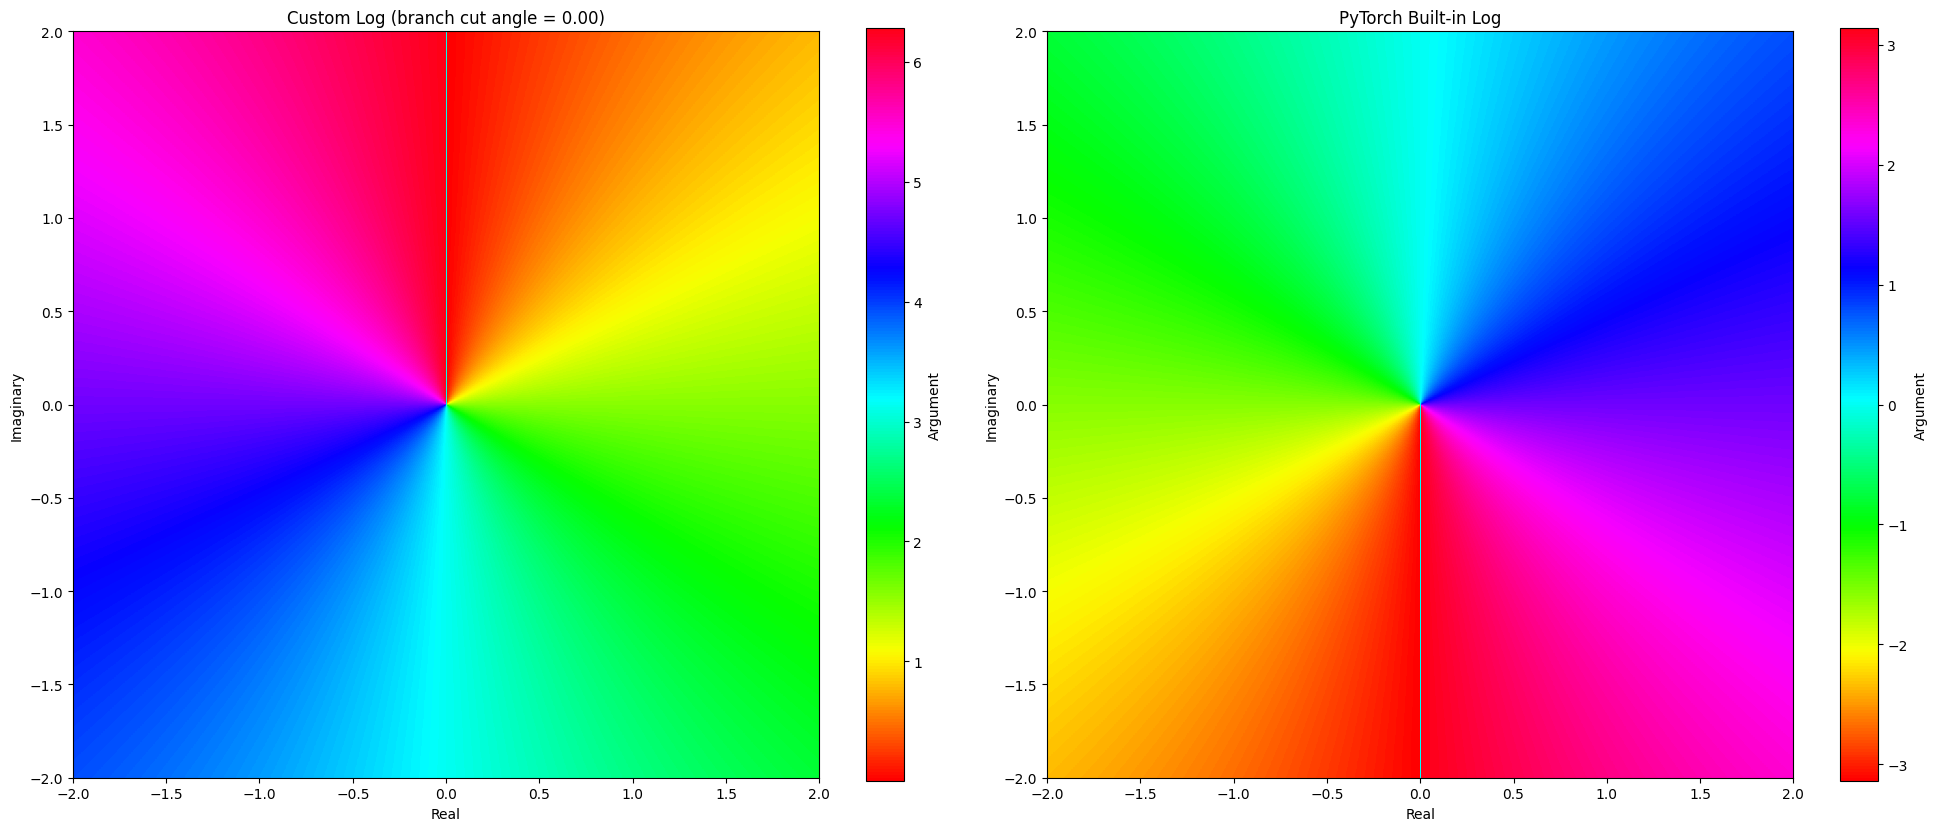

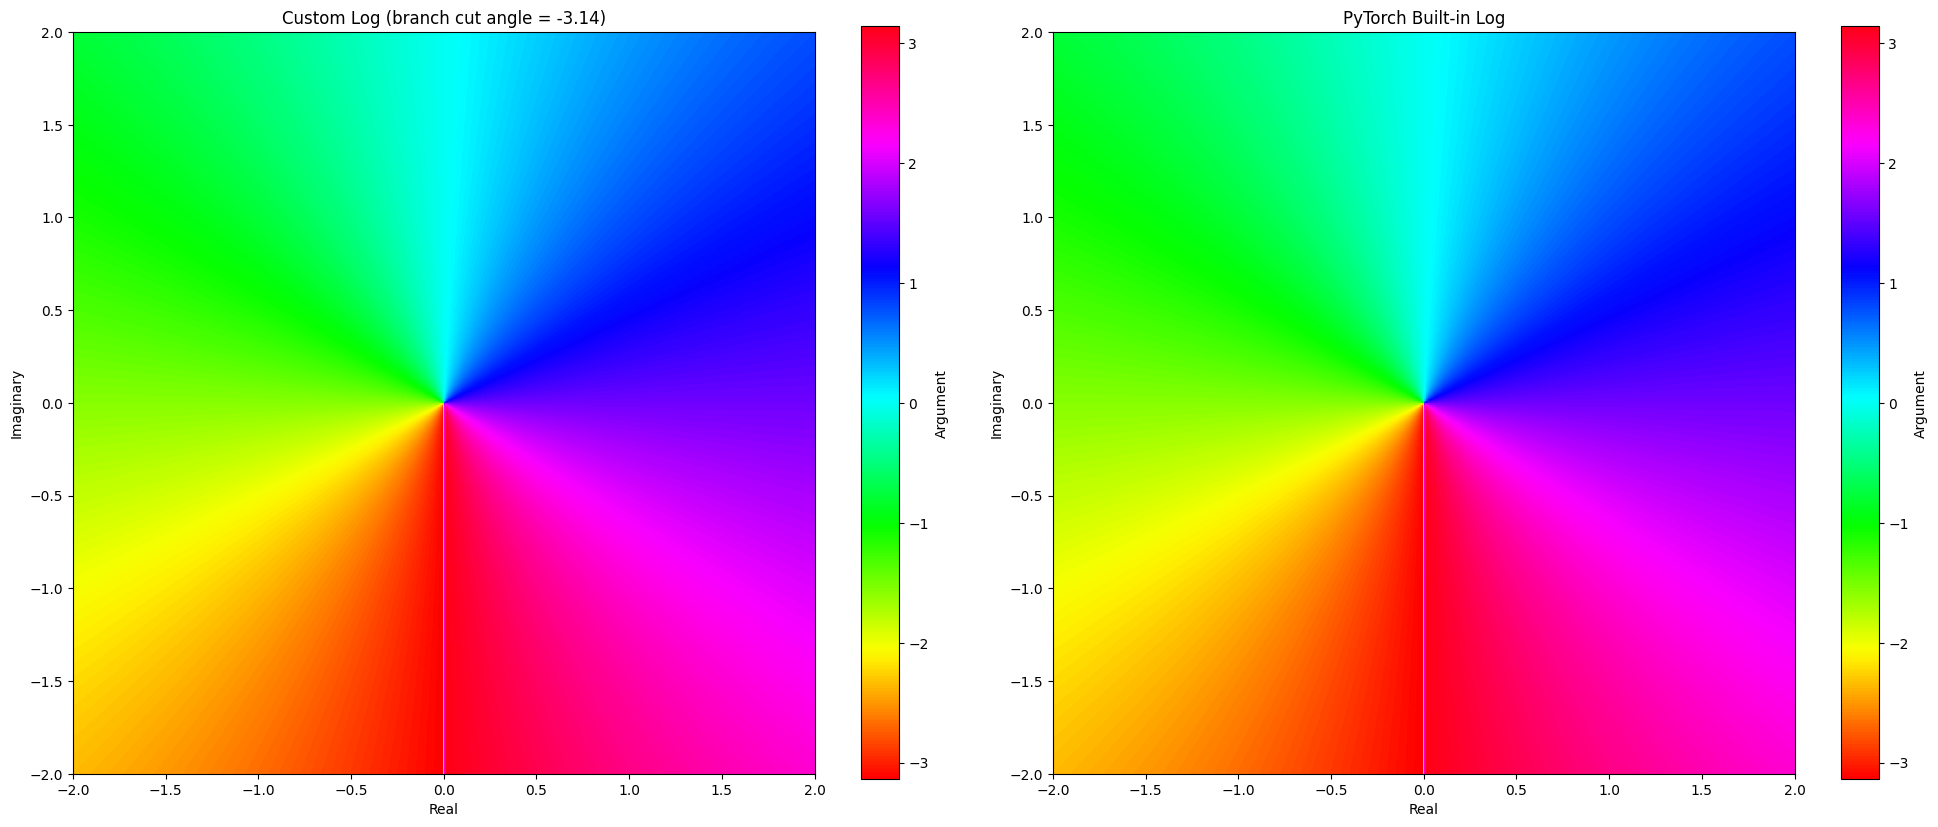

In [5]:
plot_log_phase_comparison(0)
plot_log_phase_comparison(-torch.pi)

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import AFAI_library as afai
import AFAI_library_torch as afai_cuda
import AFAI_parallelGPU as afai_parallel
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed

In [9]:
period = 2
hopping1 = - np.pi/(2 * period)
hopping2 = - 3 * np.pi/(2 * period)
hopping3 = - 5 * np.pi/(2 * period)
np.set_printoptions(linewidth=300)

In [10]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(1)}")

CUDA available: True
Current device: 0
Device name: NVIDIA A30


In [11]:
model_pest = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping1, num_y=1, device="cuda:1")

In [12]:
model_pest3 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping3, num_y=1, device="cuda:1")

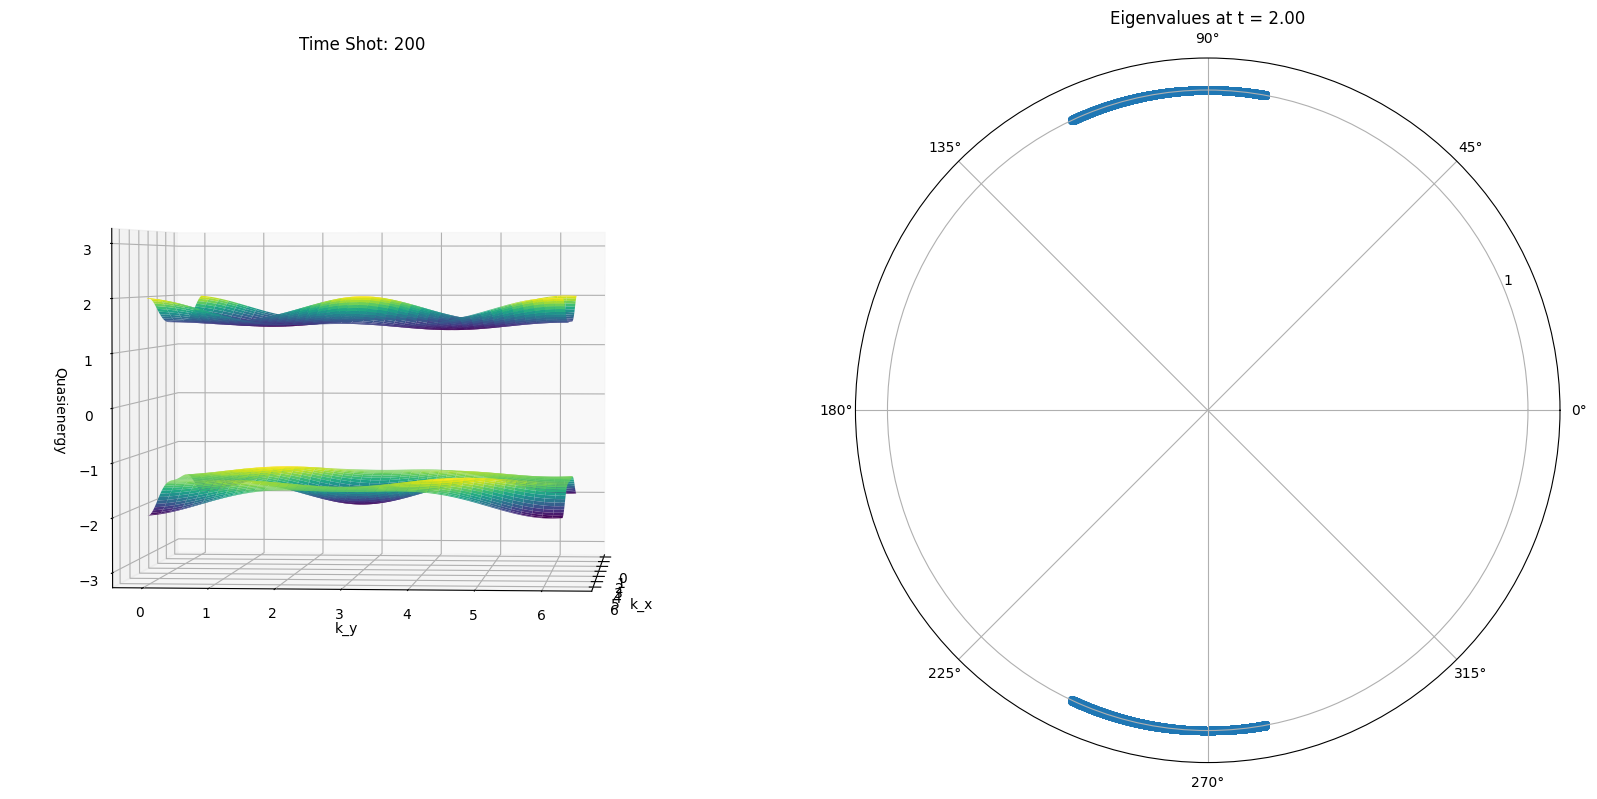

In [12]:
x = model_pest.animate_combined_spectra(200, 1000, filename="pi_2period.mp4")

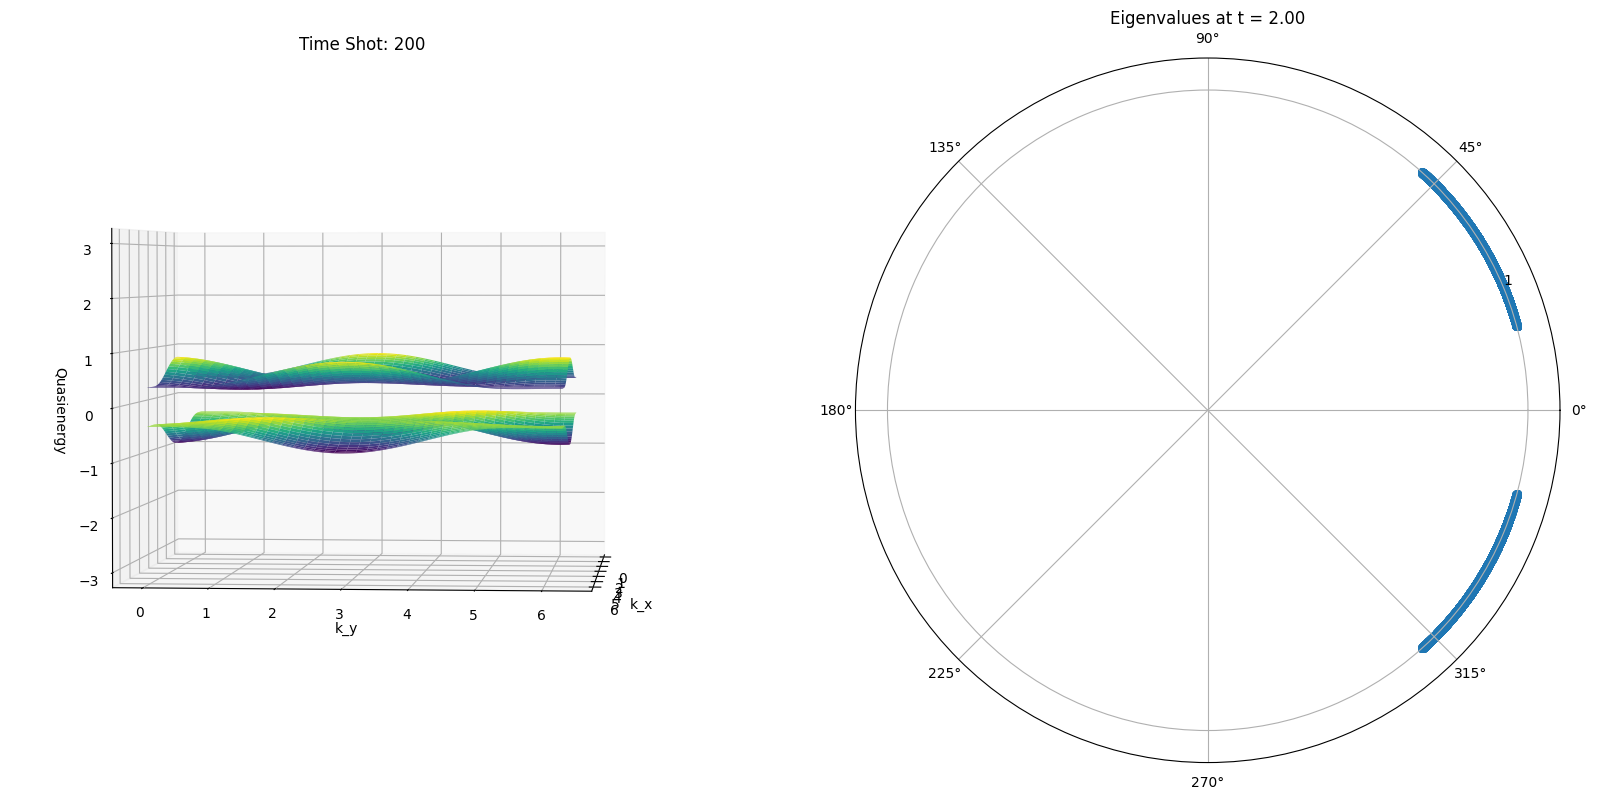

In [10]:
xxxx = model_pest3.animate_combined_spectra(200, 1000, filename="5pi_2period.mp4")

In [13]:
model_tts = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping1, ny= 2, nx = 2, device='cuda:1')
model_fti = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping2, ny = 2, nx = 2, device='cuda:1')
model_ano_flo = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping3, ny=2, nx=2, device='cuda:1')

In [14]:
vd1 = 7 * period

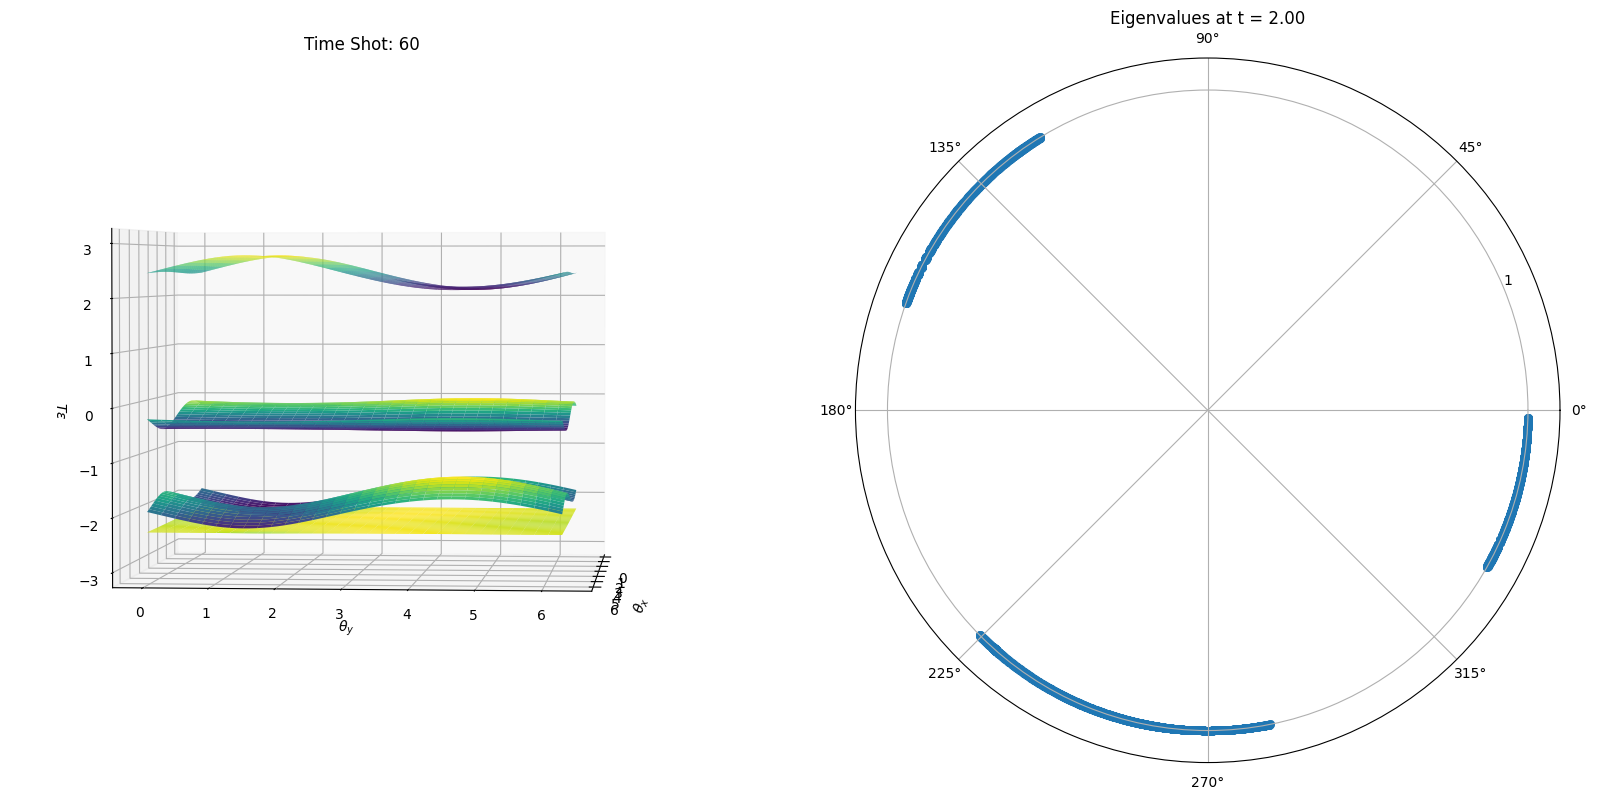

In [17]:
video_ano = model_fti.animate_time_spectra(vd1, 60, 1000, fully_disorder= True, filename = "afai_vd1.mp4")

In [25]:
vd = torch.tensor([1,2,3,4])

In [19]:
quasienergy, eigenvector = model_fti.quasienergies_states_bulk(100, vd, 0, 0, fully_disorder=True)

torch.Size([4, 4, 4])


In [21]:
print(eigenvector.shape)

torch.Size([4, 4, 4])


In [26]:
period1 = 4
period2 = 100
hopping1 = - np.pi/(2)
hopping2 = - 3 * np.pi/(2)
hopping3 = - 5 * np.pi/(2)
model_afai2 = afai_parallel.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 40, nx = 40, device='cuda:1')
# model_afai3 = afai_parallel.tb_floquet_tbc_cuda(period2, 1, hopping3, ny = 40, nx = 40, device='cuda:1')
model_afai2_4band = afai_parallel.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 2, nx = 2, device='cuda:1')
# model_afai2_cuda = afai_cuda.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 40, nx = 40, device='cuda:1')
# model_afai3_cuda = afai_cuda.tb_floquet_tbc_cuda(period2, 1, hopping3, ny = 40, nx = 40, device='cuda:1')
model_afai2_obc = afai_parallel.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 2, nx = 40, device='cuda:1')
# model_afai3_obc = afai_parallel.tb_floquet_tbc_cuda(period2, 1, hopping3, ny = 2, nx = 40, device='cuda:1')

In [5]:
vd = torch.linspace(0.5, 9, 20)
print(vd)

tensor([0.5000, 0.9474, 1.3947, 1.8421, 2.2895, 2.7368, 3.1842, 3.6316, 4.0789,
        4.5263, 4.9737, 5.4211, 5.8684, 6.3158, 6.7632, 7.2105, 7.6579, 8.1053,
        8.5526, 9.0000])


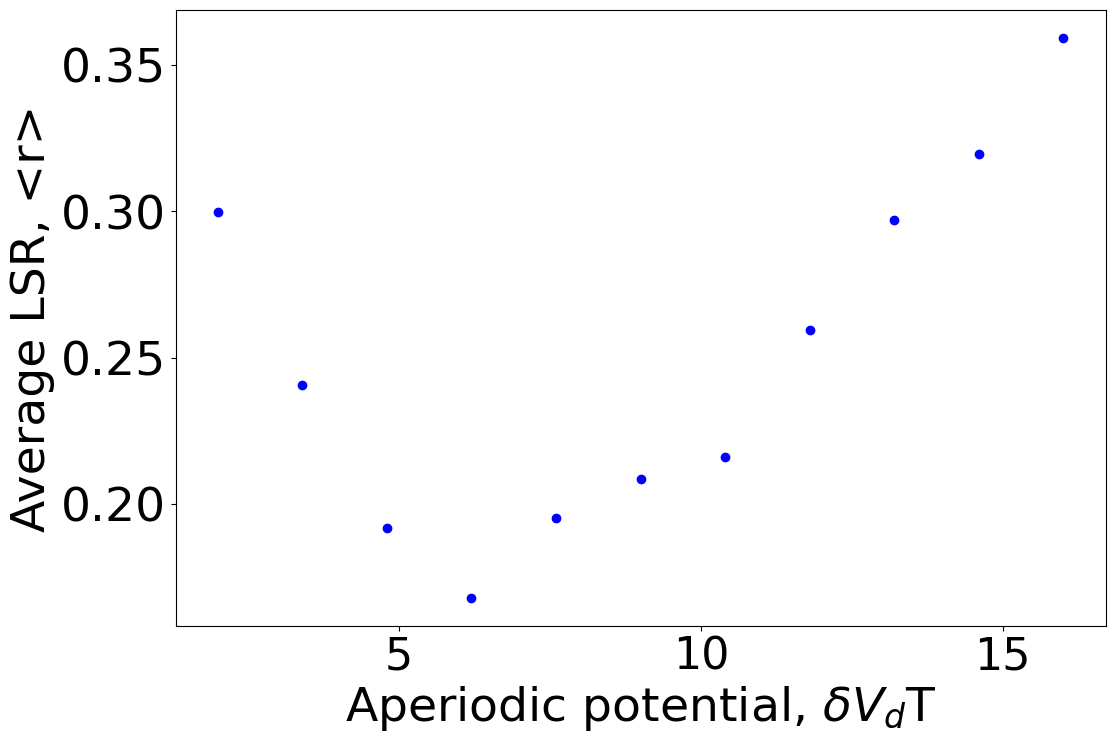

In [52]:
# avg = model_afai2_cuda.avg_level_spacing_bulk_vd(0.5, 4, 11, fully_disorder=False, plot = True)

/local/data/public/yl2010/MPhil_project/AFAI_parallelGPU.py:1648: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotation_angle_tensor = torch.tensor(rotation_angle, device=self.device)  # Convert to tensor


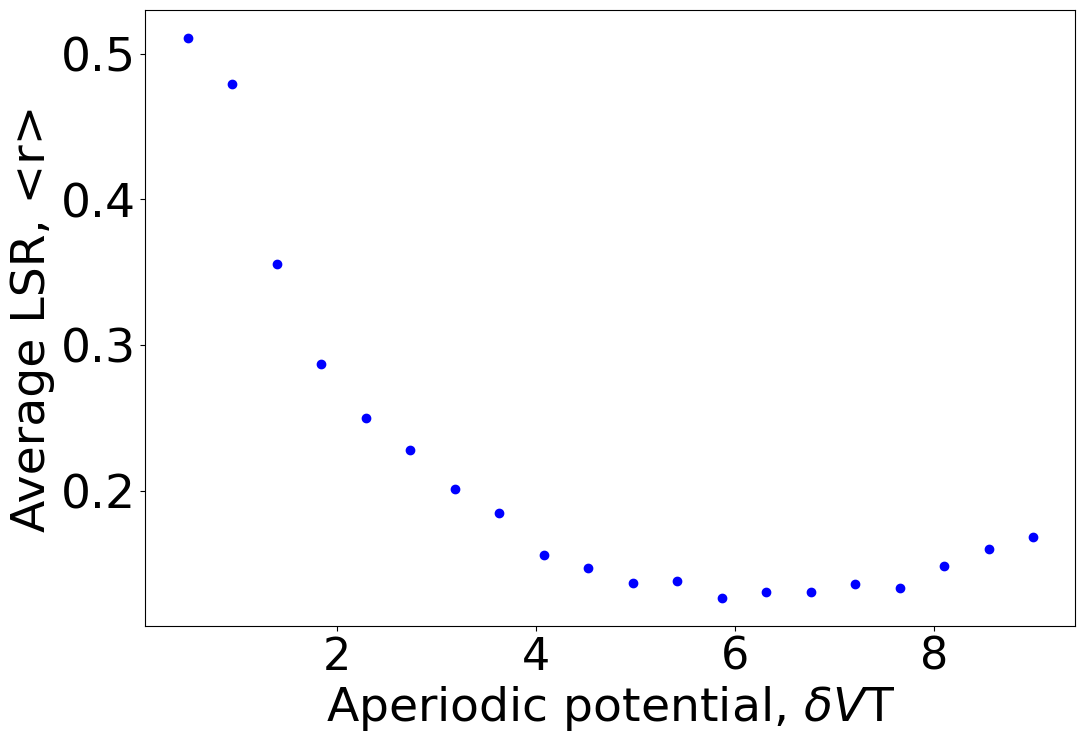

In [6]:
avg_LSR1 = model_afai2.avg_level_spacing_bulk(100, vd, fully_disorder=False, plot=True)

To see when band labeling become problematic

In [10]:
vd = torch.tensor([1,2])

In [17]:
branch_cut_angles = torch.linspace(-torch.pi, torch.pi, 30)

In [46]:
model_afai4_obc = afai_parallel.tb_floquet_tbc_cuda(2, 1, hopping3, ny = 2, nx = 80, device='cuda:1')

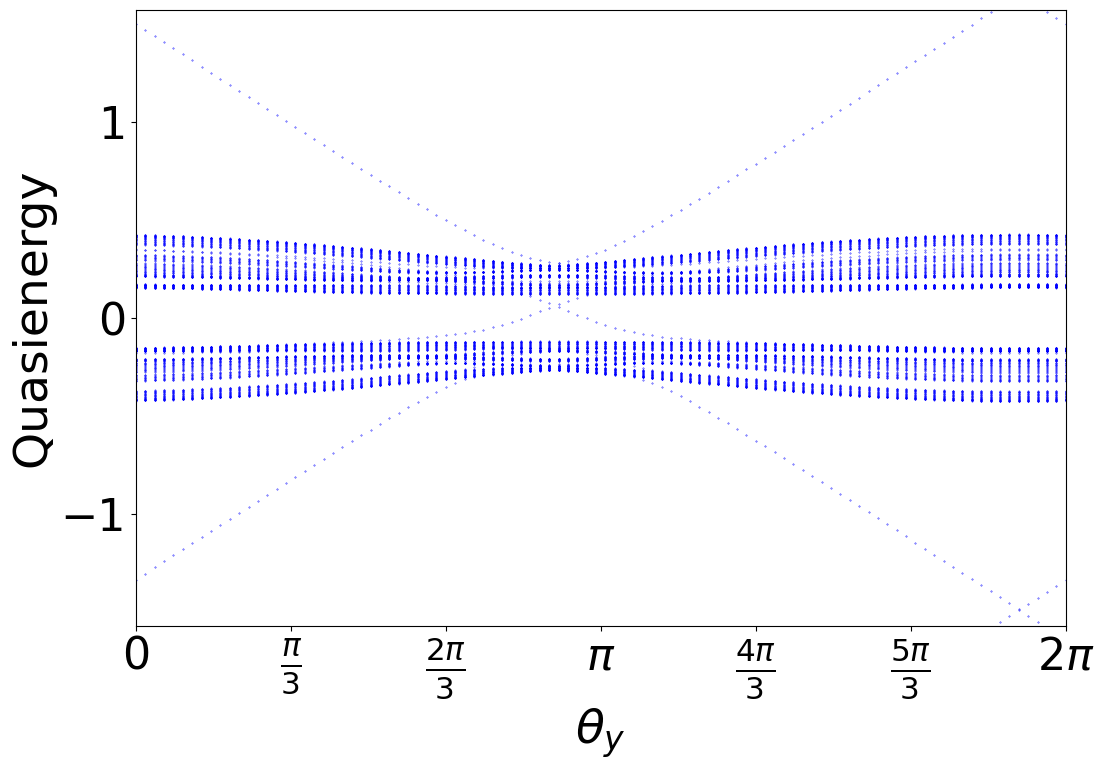

In [56]:
quasi_spectra1 = model_afai4_obc.quasienergies_states_edge(100, 'y', 0.3, theta_p_num=100, fully_disorder= False, plot= True)

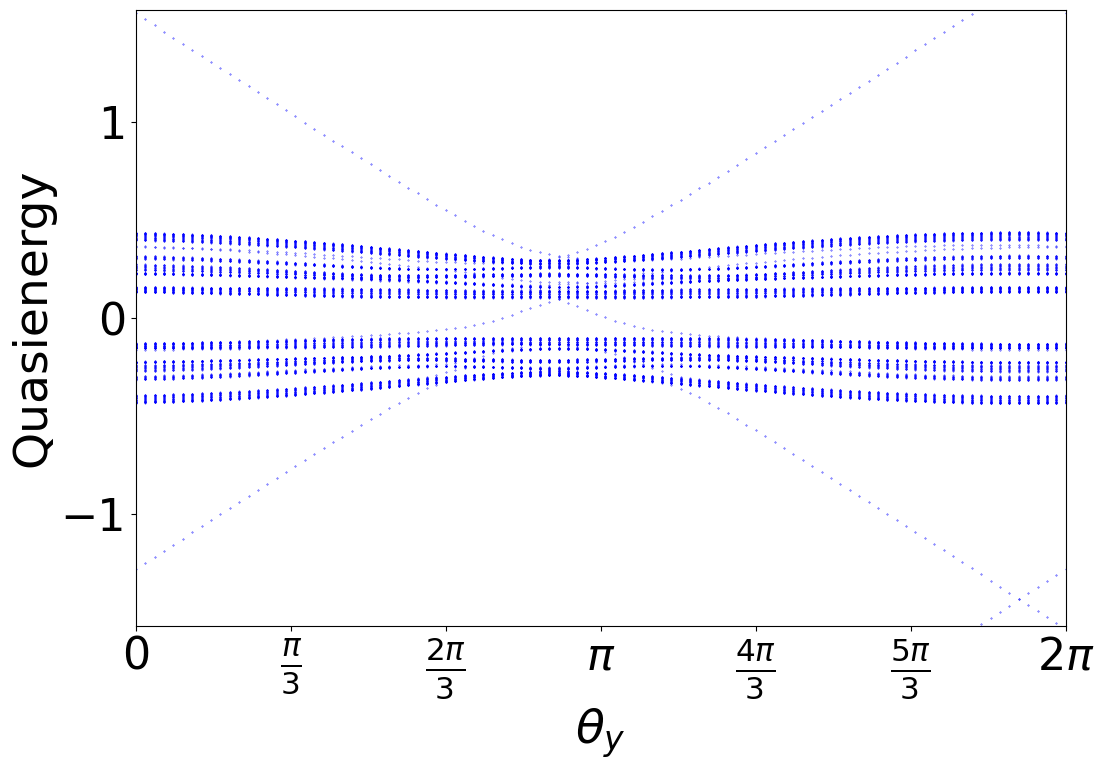

In [57]:
quasi_spectra1 = model_afai4_obc.quasienergies_states_edge(100, 'y', 0.5, theta_p_num=100, fully_disorder= False, plot= True)

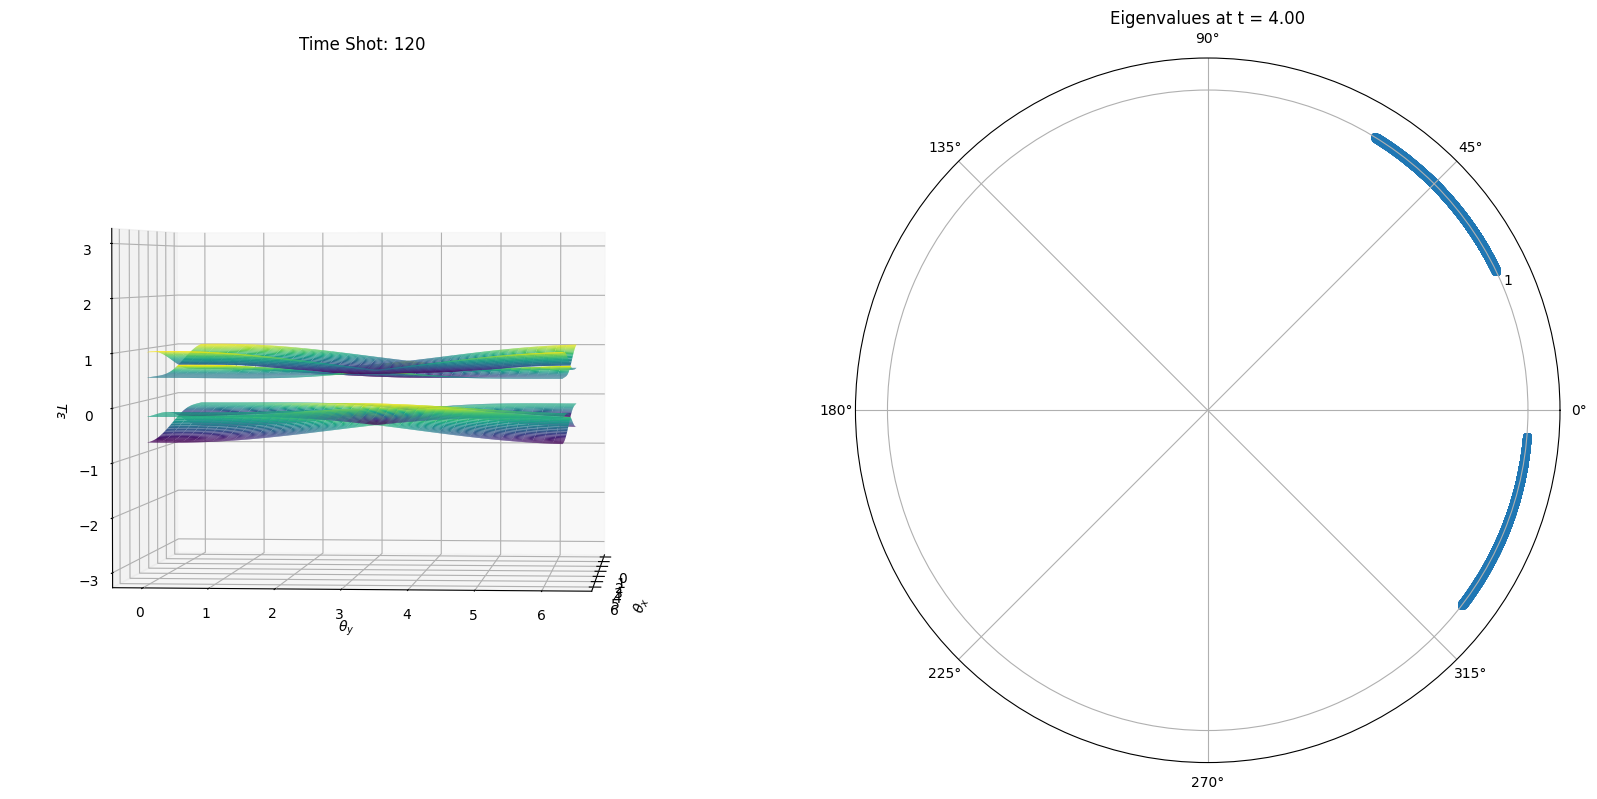

In [5]:
video_ano1 = model_afai2_4band.animate_time_spectra(0.5, 120, 100, fully_disorder=False, filename='afai_4bands1_quasi.mp4')

tensor(2., device='cuda:1', dtype=torch.float64)
tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0428, -0.0753,  1.4364,  1.0000,  1.0000,
         0.9364,  0.9247,  0.9572,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000], device='cuda:1')


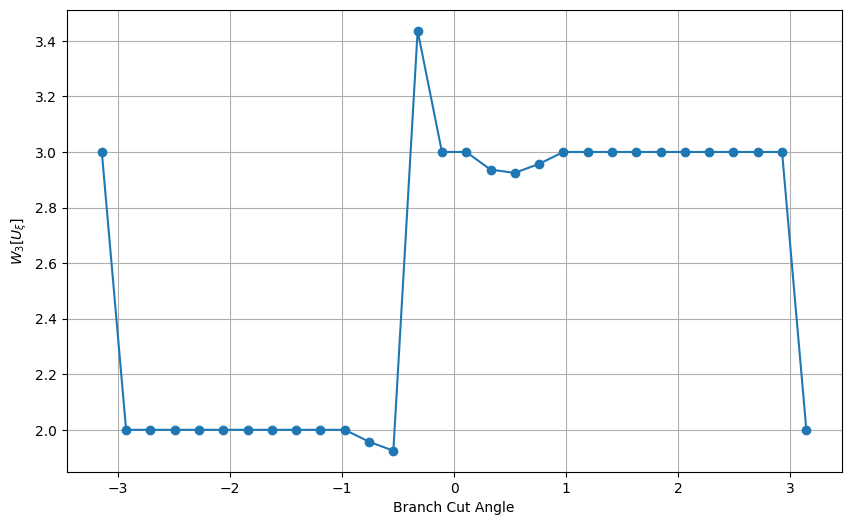

In [93]:
winding3_1 = model_afai2_4band.winding3(0, 8, 1000, branch_cut_angle=branch_cut_angles, fully_disorder=False, plot= True)

tensor(1., device='cuda:1', dtype=torch.float64)
tensor([ 4.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0350, -0.1048,  3.8695,  4.0000,  4.0000,
         3.8695,  3.8952,  3.9650,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,
         4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  0.0000], device='cuda:1')


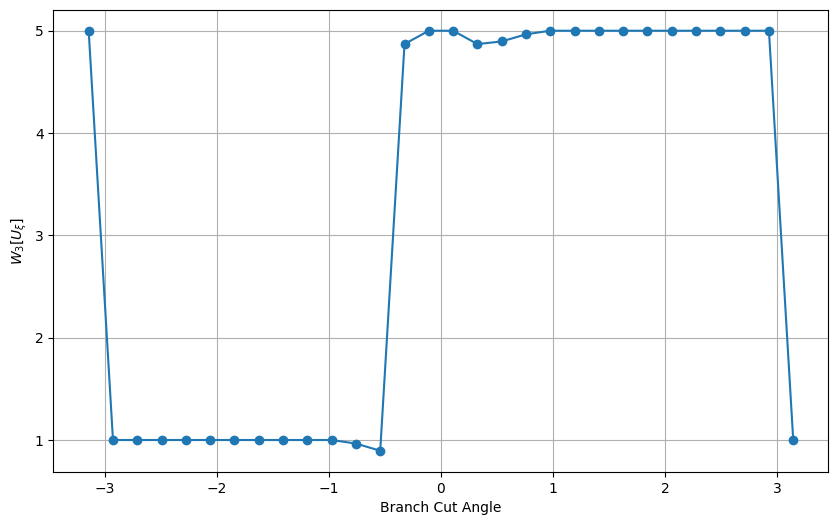

In [94]:
winding3_1 = model_afai2_4band.winding3(0, 10, 1000, branch_cut_angle=branch_cut_angles, fully_disorder=False, plot= True)

tensor(1., device='cuda:1', dtype=torch.float64)
tensor([ 3.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0383, -0.1216,  2.8783,  3.0000,  3.0000,
         2.8783,  2.8784,  2.9617,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,
         3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  0.0000], device='cuda:1')


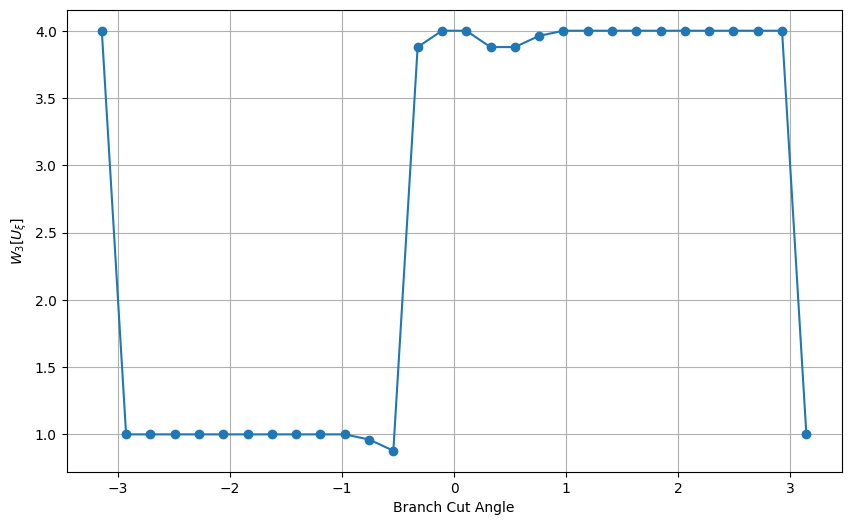

In [97]:
winding3_1 = model_afai2_4band.winding3(0, 15, 10000, branch_cut_angle=branch_cut_angles, fully_disorder=False, plot= True)

tensor(1., device='cuda:1', dtype=torch.float64)
tensor([ 5.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0403, -0.1144,  3.8842,  5.0000,  5.0000,
         4.8842,  4.8856,  4.9597,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,
         5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  0.0000], device='cuda:1')


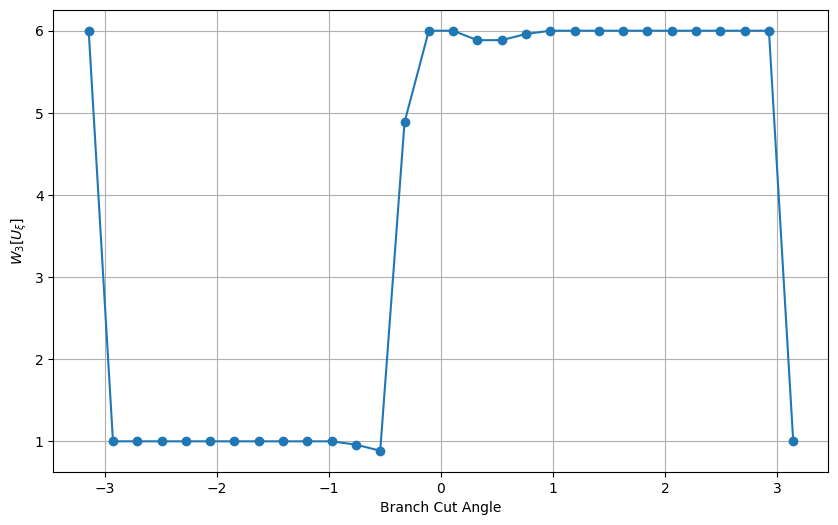

In [98]:
winding3_1 = model_afai2_4band.winding3(0, 16, 10000, branch_cut_angle=branch_cut_angles, fully_disorder=False, plot= True)

tensor(3., device='cuda:1', dtype=torch.float64)
tensor([ 8.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0398, -0.1283,  7.8694,  8.0000,  8.0000,
         7.8694,  7.8717,  7.9602,  8.0000,  8.0000,  8.0000,  8.0000,  8.0000,
         8.0000,  8.0000,  8.0000,  8.0000,  8.0000,  0.0000], device='cuda:1')


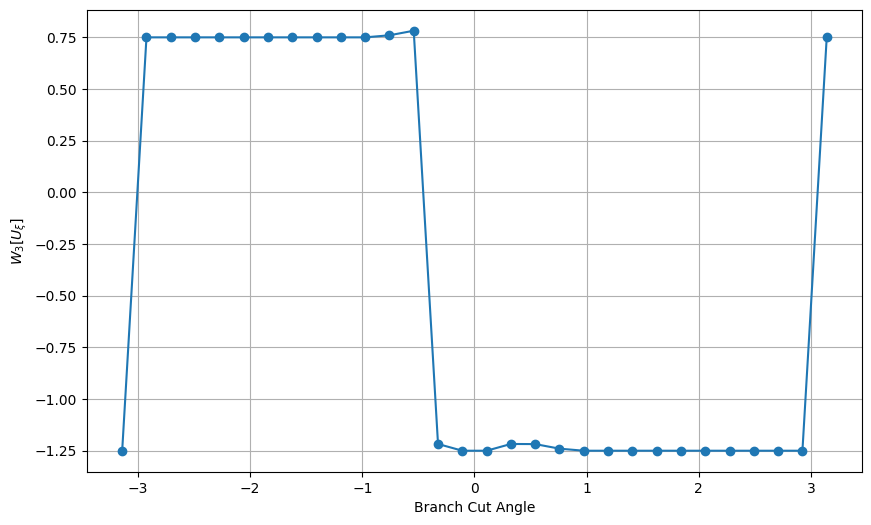

In [100]:
winding3_1 = model_afai2_4band.winding3(0, 50, 10000, branch_cut_angle=branch_cut_angles, fully_disorder=False, plot= True)

In [70]:
w3 = model_afai2_4band.w3(0.05, 20, 100, fully_disorder=False)

($i_1, i_2, i_3$) 1 1 11
p tensor([0.3142, 0.3142, 2.2000], device='cuda:1', dtype=torch.float64)
$C_p$ tensor([-1.,  1.,  1., -1.], device='cuda:1', dtype=torch.float64)
$M_p$ tensor([-0., 0., -0., 0.], device='cuda:1', dtype=torch.float64)
$F_p$ tensor([[ 1.5210e-01, -1.5230e-01, -1.7000e-01,  1.7013e-01],
        [ 3.2462e-01, -3.2455e-01, -3.2824e-01,  3.2825e-01],
        [ 6.1722e-04, -4.3041e-05,  4.3037e-05, -6.1721e-04]], device='cuda:1',
       dtype=torch.float64)


($i_1, i_2, i_3$) 1 1 20
p tensor([0.3142, 0.3142, 4.0000], device='cuda:1', dtype=torch.float64)
$C_p$ tensor([-0., -0., 1., -0.], device='cuda:1', dtype=torch.float64)
$M_p$ tensor([0., 0., 0., 0.], device='cuda:1', dtype=torch.float64)
$F_p$ tensor([[-4.6107e-03,  4.1305e-02, -4.9856e-01, -4.8813e-01],
        [ 1.2077e-02, -1.6713e-02, -8.2867e-03,  1.2923e-02],
        [ 6.8630e-04, -3.1841e-05,  3.1841e-05, -6.8630e-04]], device='cuda:1',
       dtype=torch.float64)


($i_1, i_2, i_3$) 1 2 3
p tensor([0.314

In [71]:
print(w3)

tensor(1., device='cuda:1', dtype=torch.float64)


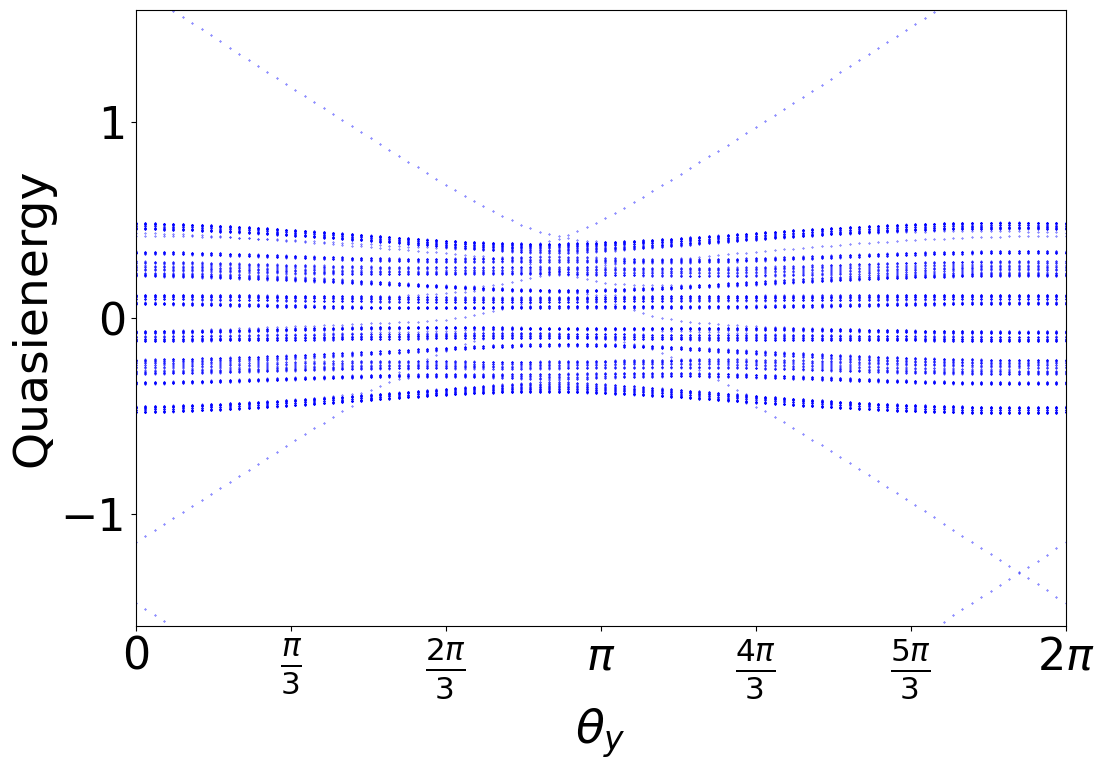

In [58]:
quasi_spectra1 = model_afai4_obc.quasienergies_states_edge(100, 'y', 1, theta_p_num=100, fully_disorder= False, plot= True)

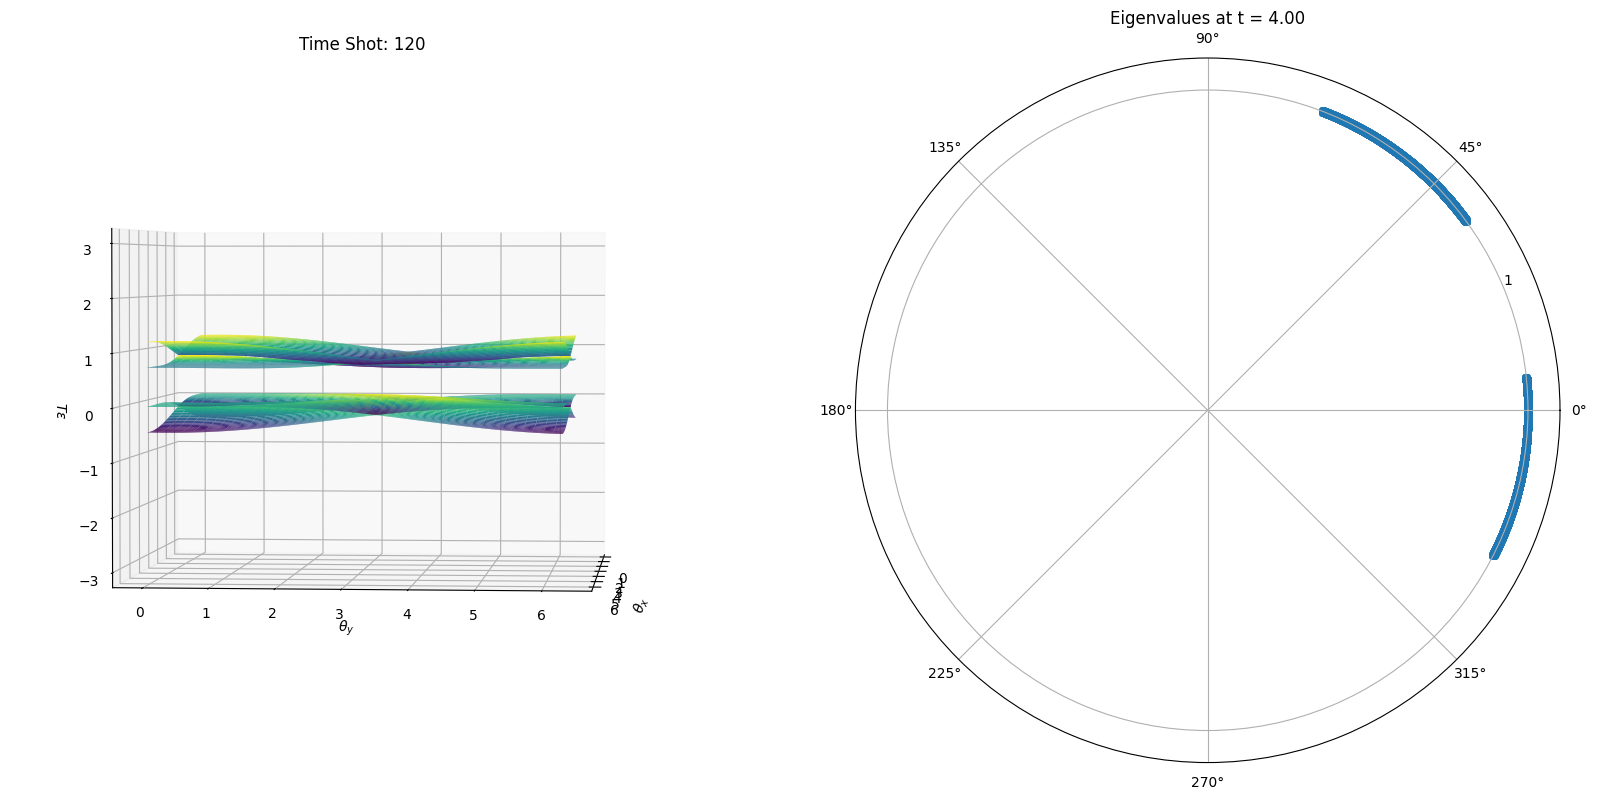

In [6]:
video_ano2 = model_afai2_4band.animate_time_spectra(1, 120, 100, fully_disorder=False, filename='afai_4bands2_quasi.mp4')

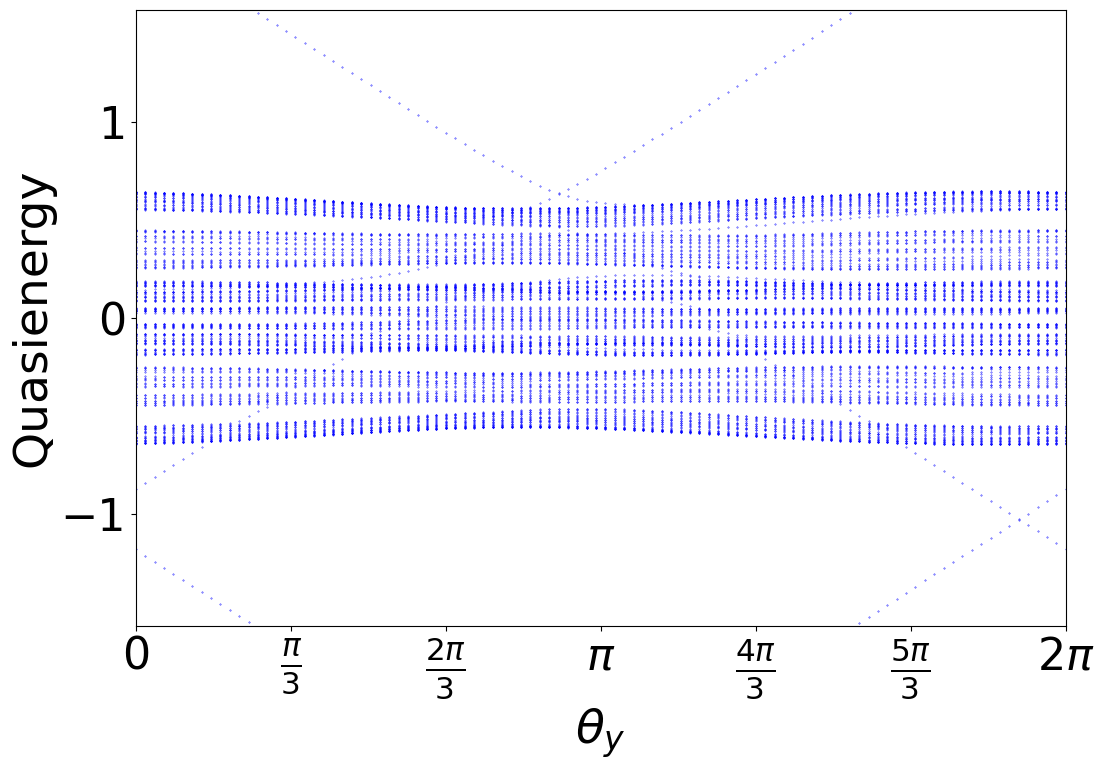

In [59]:
quasi_spectra1 = model_afai4_obc.quasienergies_states_edge(100, 'y', 2, theta_p_num=100, fully_disorder= False, plot= True)

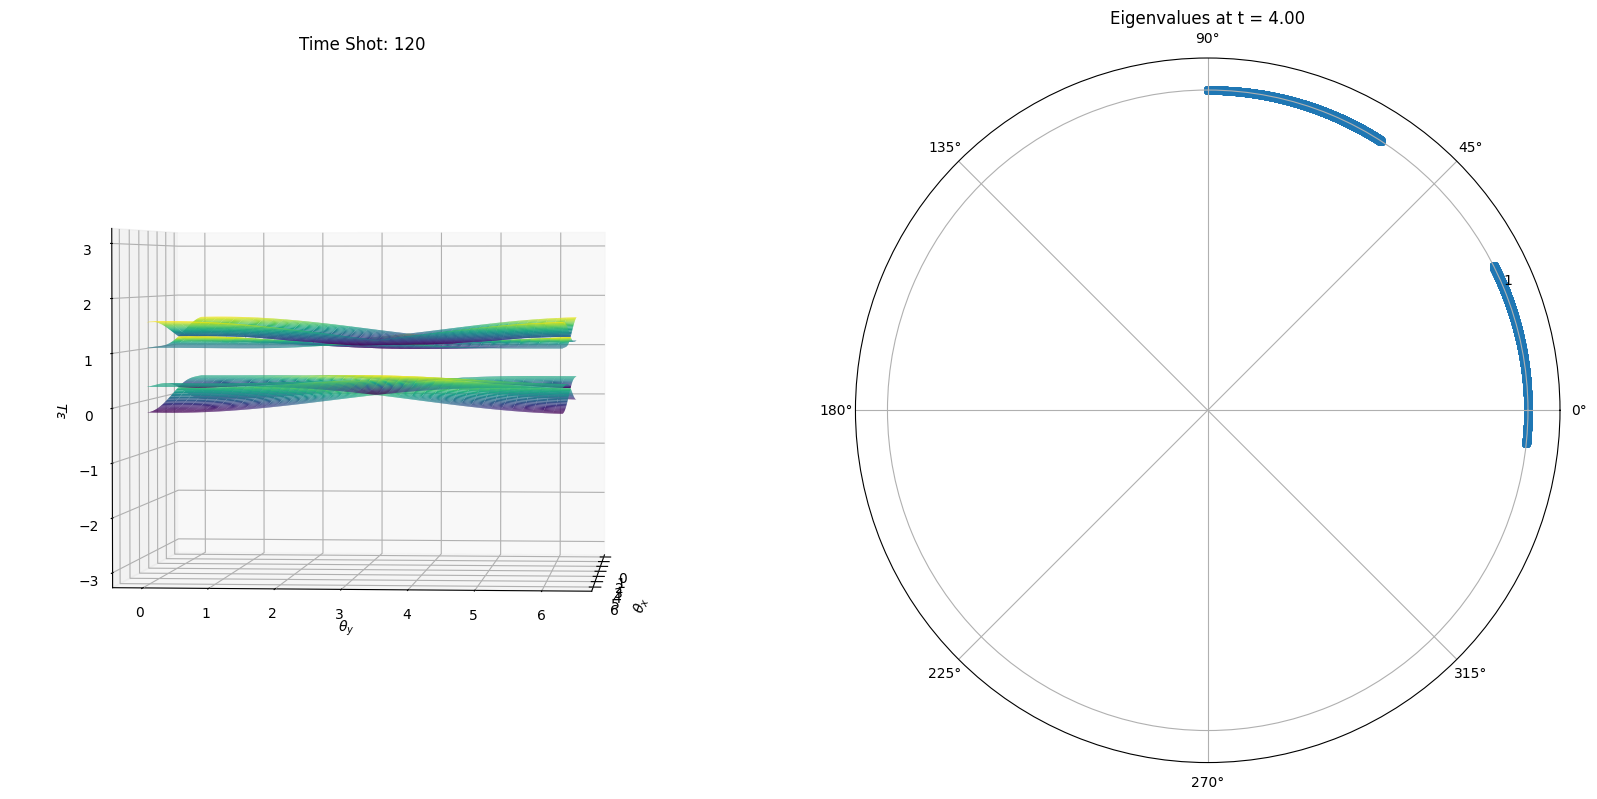

In [7]:
video_ano3 = model_afai2_4band.animate_time_spectra(2, 120, 100, fully_disorder=False, filename='afai_4bands3_quasi.mp4')

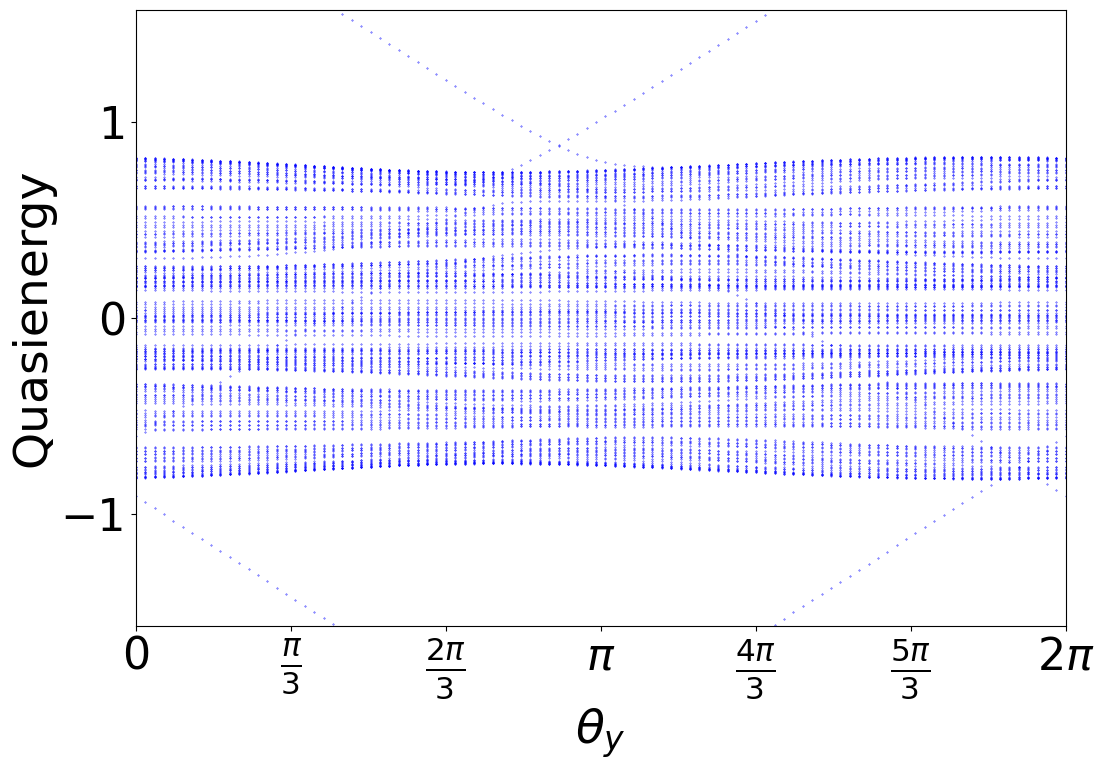

In [60]:
quasi_spectra1 = model_afai4_obc.quasienergies_states_edge(100, 'y', 3, theta_p_num=100, fully_disorder= False, plot= True)

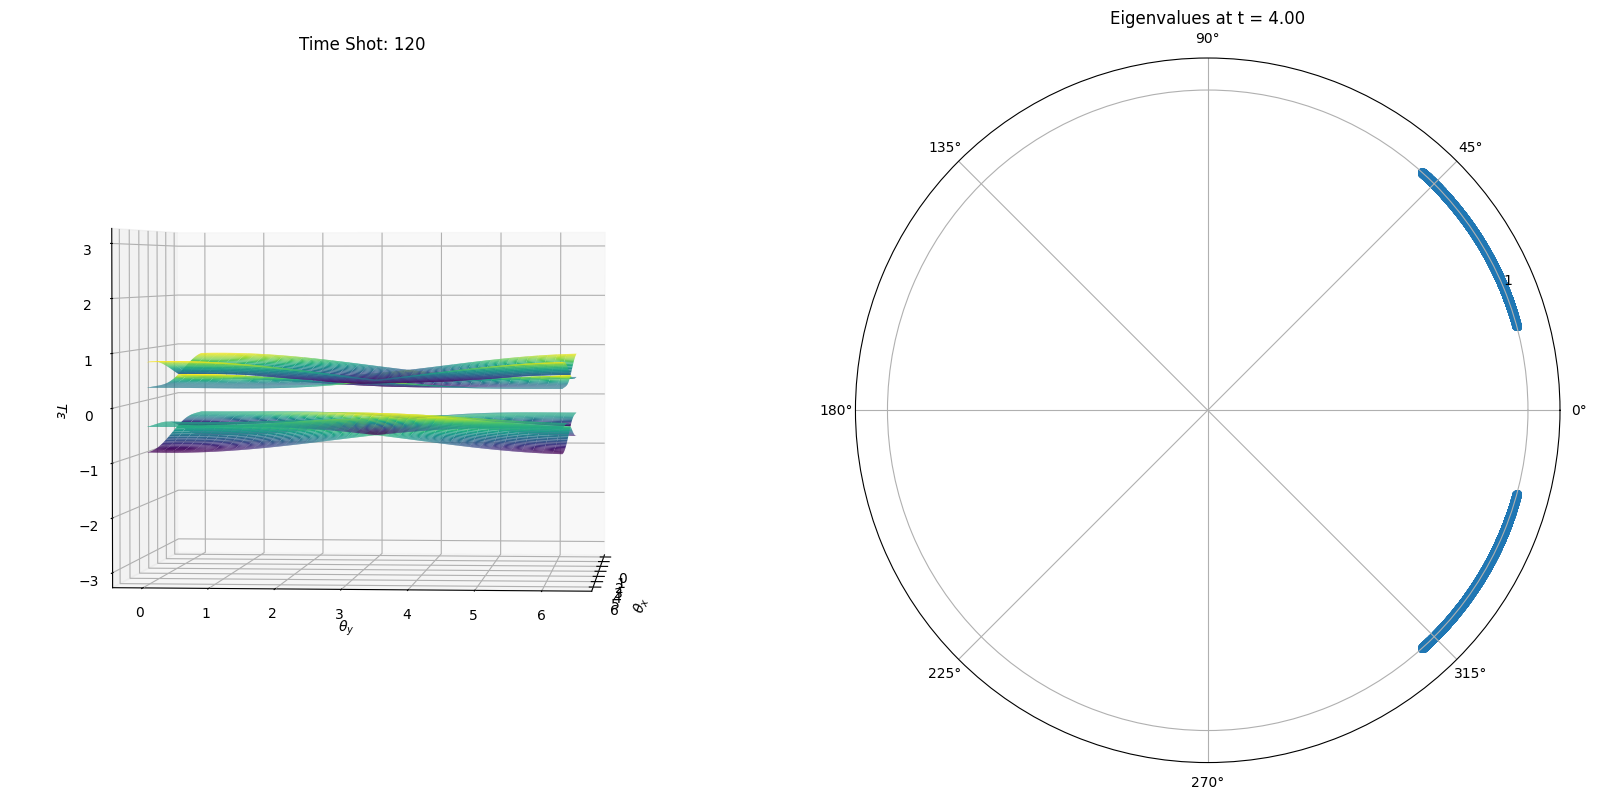

In [8]:
video_ano2 = model_afai2_4band.animate_time_spectra(0, 120, 100, fully_disorder=False, filename='afai_4bands0.mp4')

1. Fully disorder: Need to calculate winding number average over large disorder realisation(?)
Create a few videos for different disorder strength (starting from small disorder strength) to see the multiband effects.
winding number calculation
quantised charge pumping

2. Quasiperiodic: For the central flower configuration where phi1 and phi2 = 0
Choose a few quasiperiodic strength to see the multiband effect starting from small quasiperiodic strength (vdT = [0.3, 0.5, 1, 2, 3])
winding number calculation
quantised charge pumping

3. Create overlap between sites and the continuous quasiperiodic pattern to see the symmetry effects.

4. the Hamiltonian 

In [25]:
model_afai2_2band = afai_parallel.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 1, nx = 2, device='cuda:1')

In [27]:
sorted_eigvalue, _, sort_eigvecs = model_afai2_2band.eigen_grid(0, 3, 1000)

In [32]:
print("sorted_eigvalue shape:", sorted_eigvalue.shape)
print("sort_eigvecs shape:", sort_eigvecs.shape)

sorted_eigvalue shape: torch.Size([4, 4, 4, 2])
sort_eigvecs shape: torch.Size([4, 4, 4, 2, 2])


In [47]:
reorder_eigvalue, reorder_eigvecs = model_afai2_2band.reorder_eigenvalues_eigenvectors(sorted_eigvalue, sort_eigvecs)

Input shapes - eigvals: torch.Size([4, 4, 4, 2]), eigvecs: torch.Size([4, 4, 4, 2, 2])
Reference eigvecs shape: torch.Size([2, 2])
Inner products shape at (0,0,0): torch.Size([2, 2])
Indices shape: torch.Size([2]), values: tensor([0, 1], device='cuda:1')
Next reference point: (0,0,0)
Inner products shape at (0,0,1): torch.Size([2, 2])
Indices shape: torch.Size([2]), values: tensor([1, 0], device='cuda:1')
Next reference point: (0,0,1)
Inner products shape at (0,0,2): torch.Size([2, 2])
Indices shape: torch.Size([2]), values: tensor([0, 1], device='cuda:1')
Next reference point: (0,0,2)
Inner products shape at (0,0,3): torch.Size([2, 2])
Indices shape: torch.Size([2]), values: tensor([0, 1], device='cuda:1')
Next reference point: (0,0,0)
Inner products shape at (0,1,0): torch.Size([2, 2])
Indices shape: torch.Size([2]), values: tensor([0, 1], device='cuda:1')
Next reference point: (0,1,0)
Inner products shape at (0,1,1): torch.Size([2, 2])
Indices shape: torch.Size([2]), values: tensor(

In [42]:
print(reorder_eigvecs[:,:,0])

tensor([[[[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]]],


        [[[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]]],


        [[[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]]],


        [[[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],

         [[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]]]], device='cuda:1', dtype=torch.complex128)


In [57]:
print(reorder_eigvecs[:,0,-2])

tensor([[[ 0.7539+0.0000j, -0.6566+0.0236j],
         [ 0.6566+0.0236j,  0.7539+0.0000j]],

        [[ 0.3312+0.3514j,  0.8757+0.0000j],
         [ 0.8757+0.0000j, -0.3312+0.3514j]],

        [[ 0.8120+0.0000j, -0.2522+0.5263j],
         [ 0.2522+0.5263j,  0.8120+0.0000j]],

        [[ 0.7539+0.0000j, -0.6566+0.0236j],
         [ 0.6566+0.0236j,  0.7539+0.0000j]]], device='cuda:1',
       dtype=torch.complex128)


In [30]:
print(sort_eigvecs[:,:,-1])

tensor([[[[-0.2407+1.5658e-08j,  0.9706+0.0000e+00j],
          [ 0.9706+0.0000e+00j,  0.2407+1.5658e-08j]],

         [[-0.2407+1.5658e-08j,  0.9706+0.0000e+00j],
          [ 0.9706+0.0000e+00j,  0.2407+1.5658e-08j]],

         [[-0.2407+1.5658e-08j,  0.9706+0.0000e+00j],
          [ 0.9706+0.0000e+00j,  0.2407+1.5658e-08j]],

         [[-0.2407+1.5658e-08j,  0.9706+0.0000e+00j],
          [ 0.9706+0.0000e+00j,  0.2407+1.5658e-08j]]],


        [[[ 0.9794+0.0000e+00j,  0.1010-1.7488e-01j],
          [-0.1010-1.7488e-01j,  0.9794+0.0000e+00j]],

         [[ 0.9794+0.0000e+00j,  0.1010-1.7488e-01j],
          [-0.1010-1.7488e-01j,  0.9794+0.0000e+00j]],

         [[ 0.9794+0.0000e+00j,  0.1010-1.7488e-01j],
          [-0.1010-1.7488e-01j,  0.9794+0.0000e+00j]],

         [[ 0.9794+0.0000e+00j,  0.1010-1.7488e-01j],
          [-0.1010-1.7488e-01j,  0.9794+0.0000e+00j]]],


        [[[ 0.0752+1.3021e-01j,  0.9886+0.0000e+00j],
          [ 0.9886+0.0000e+00j, -0.0752+1.3021e-01j]],

      

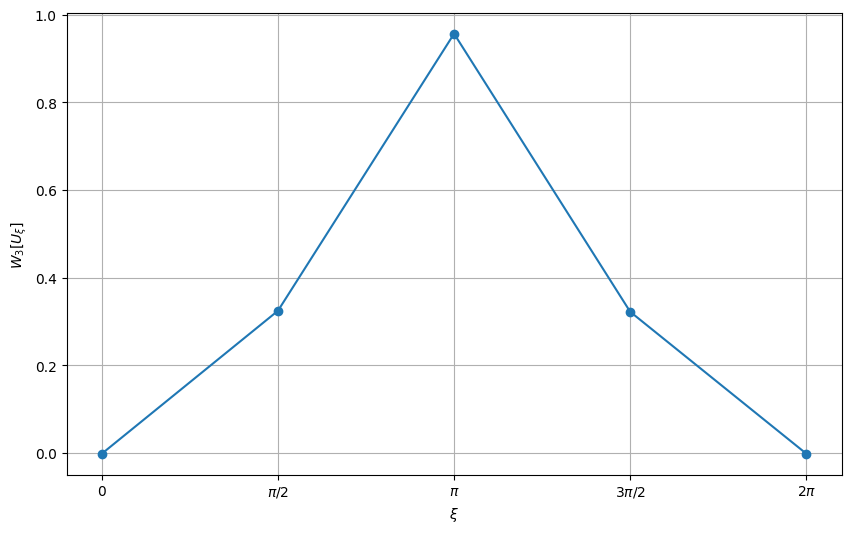

In [44]:
model_tbc2.plot_W3_vs_xi(100, 100, 200, 5, vdT=0, fully_disorder=False)

In [47]:
model_tbc2.plot_W3_vs_xi_single(10, 10, 200, 5, vdT=0, fully_disorder=False)

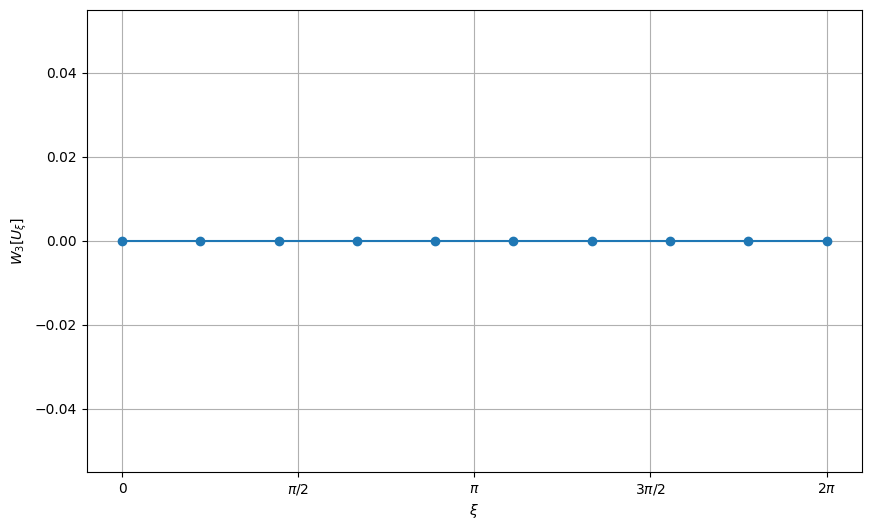

In [ ]:
model_tbc2.plot_W3_vs_xi(100, 100, 200, 11, vdT=1, fully_disorder=False)

In [ ]:
model_tbc3.plot_W3_vs_xi(100, 100, 200, 11, vdT=0, fully_disorder=False)

KeyboardInterrupt: 

In [ ]:
model_tbc3.plot_W3_vs_xi(100, 100, 200, 11, vdT=1, fully_disorder=False)